#### IMPORT PACKAGES

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

### LOAD DATASET (1 Year)

[Source](https://www.blockchain.com/explorer/charts)

In [3]:
directory = os.path.abspath("") + '/dataset/bitcoin/'
data = pd.read_json(directory + 'data.json')
tps = pd.read_json(directory + 'tps.json')

### CLASSICAL SIGNATURE (ECDSA) EVALUATION

#### RENAME FEATURES

In [4]:
ECDSA = data.copy()

ECDSA_TPS = tps.copy()

ECDSA.rename(columns = {'n-transactions-per-block': 'NoTxPerBlock', 'avg-block-size': 'AvgBlockSize', 'fees-usd-per-transaction': 'FeePerTx', 'market-price': 'MarketPrice'}, inplace = True)

#### FEATURE EXTRACTION

In [5]:
# Extract corresponding values from object
ECDSA['Timestamp'] = ECDSA['NoTxPerBlock'].apply(lambda x: x['x'])

# Convert milliseconds to seconds
ECDSA['Timestamp'] = ECDSA['Timestamp'] / 1000

ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))

ECDSA['NoTxPerBlock'] = ECDSA['NoTxPerBlock'].apply(lambda x: x['y'])

ECDSA['MarketPrice'] = ECDSA['MarketPrice'].apply(lambda x: x['y'])

# dollars
ECDSA['FeePerTx'] = ECDSA['FeePerTx'].apply(lambda x: x['y'])

# # bitcoin 
ECDSA['FeePerTx'] = ECDSA['FeePerTx'] / ECDSA['MarketPrice']

# Average block size in bytes
ECDSA['AvgBlockSize'] = ECDSA['AvgBlockSize'].apply(lambda x: (x['y'] * 1000000))

ECDSA['AvgTxSize'] = ECDSA['AvgBlockSize'] / ECDSA['NoTxPerBlock']

# Max No of Transactions possible in a 4 MB
ECDSA['NoMaxTxPossible'] = (4 * 1000000) / ECDSA['AvgTxSize'].min()

ECDSA_TPS['Timestamp'] = ECDSA_TPS['transactions-per-second'].apply(lambda x: x['x'])

# Convert milliseconds to seconds
ECDSA_TPS['Timestamp'] = ECDSA_TPS['Timestamp'] / 1000

ECDSA_TPS['TPS'] = ECDSA_TPS['transactions-per-second'].apply(lambda x: x['y'])

# Perform an asof merge
ECDSA = pd.merge_asof(ECDSA, ECDSA_TPS[['Timestamp', 'TPS']], on='Timestamp', direction='nearest')

# seconds
ECDSA['BlockTime'] = ECDSA['NoTxPerBlock'] / ECDSA['TPS']

ECDSA['AvgFeeRate'] = ECDSA['FeePerTx'] / ECDSA['AvgTxSize']

ECDSA.describe()

C:\Users\ummar\AppData\Local\Temp\ipykernel_23768\1691156905.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))


,AvgBlockSize,FeePerTx,NoTxPerBlock,MarketPrice,Timestamp,Date,AvgTxSize,NoMaxTxPossible,TPS,BlockTime,AvgFeeRate
count,3.640000e+02,364.000000,364.000000,364.000000,3.640000e+02,364,364.000000,3.640000e+02,364.000000,364.000000,3.640000e+02
mean,1.734056e+06,0.000145,2933.657283,30192.799121,1.690027e+09,2023-07-22 12:00:00,643.613991,1.103532e+04,4.625237,643.612220,2.831864e-07
min,9.601554e+05,0.000023,1430.216374,20224.850000,1.674346e+09,2023-01-22 00:00:00,362.472452,1.103532e+04,2.597396,393.333328,3.641183e-08
25%,1.646416e+06,0.000059,2263.857447,26334.655000,1.682186e+09,2023-04-22 18:00:00,475.027991,1.103532e+04,3.617187,564.952766,8.111283e-08
50%,1.696631e+06,0.000084,2998.069718,28217.275000,1.690027e+09,2023-07-22 12:00:00,556.316078,1.103532e+04,4.331163,633.635239,1.177627e-07
75%,1.789486e+06,0.000172,3547.784657,30868.882500,1.697868e+09,2023-10-21 06:00:00,765.673898,1.103532e+04,5.412500,711.936310,3.199876e-07
max,2.524785e+06,0.001086,4688.147436,46972.420000,1.705709e+09,2024-01-20 00:00:00,1565.580468,1.103532e+04,10.788715,1390.893031,2.677356e-06
std,2.021616e+05,0.000153,756.139153,6249.368136,9.091180e+06,NaN,235.676182,1.821493e-12,1.291138,115.164013,3.796946e-07


#### CORRELATION MATRIX

Text(0.5, 1.0, 'Bitcoin correlation between features')

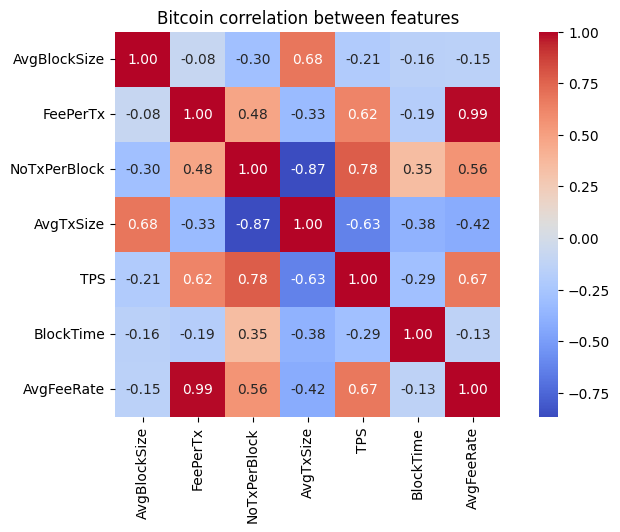

In [6]:
ECDSA_CORR = ECDSA.copy().drop(labels=['Timestamp', 'Date', 'MarketPrice', 'NoMaxTxPossible'], axis=1).corr()
plt.figure(figsize=(10,5))
sns.heatmap(ECDSA_CORR, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.title('Bitcoin correlation between features')

### COMPARISON OF POST-QUANTUM SIGNATURES

[Speed Comparison](https://openquantumsafe.org/benchmarking/visualization/speed_sig.html)

1. Level 1: Algorithm is at least as hard to break as AES128.
2. Level 2: Algorithm is at least as hard to break as SHA256.
3. Level 3: Algorithm is at least as hard to break as AES192.
4. Level 4: Algorithm is at least as hard to break as SHA384.
5. Level 5: Algorithm is at least as hard to break as AES256.

Since ECDSA 256-bit is equivalent to AES128, we will focus on Level 1 only.

#### PQ TRANSACTION SIZE FUNCTION

> Calculates the average transaction size considering the replacement of ECDSA signatures and public keys with post-quantum (PQ) signatures and public keys.

    Parameters:
    - ECDSATxSize (float): Original transaction size with ECDSA signatures and public keys.
    - PQ_SIG_SIZE (int): Size of the post-quantum signature.
    - PQ_PUB_SIZE (int): Size of the post-quantum public key.

    Returns:
    - float: Average transaction size with PQ signatures and public keys.

In [7]:
def getPQAvgTransactionSize(ECDSATxSize, PQ_SIG_SIZE: int):
    
    # ECDSA (bytes)
    ECDSA_SIG_SIZE = 72

    PQ_TxSize = ECDSATxSize - ECDSA_SIG_SIZE  + PQ_SIG_SIZE

    return PQ_TxSize

#### [FALCON-512](https://falcon-sign.info/)

* NIST LEVEL 1 Security

In [8]:
FALCON_512_SIG_SIZE = 666 # (bytes)

FALCON = pd.DataFrame()

FALCON['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], FALCON_512_SIG_SIZE)

Ts = ECDSA['NoTxPerBlock'].mean() / (176.55 / (FALCON['AvgTxSize'].mean() / 50))

Tv = ECDSA['NoTxPerBlock'].mean() / (17234 / (FALCON['AvgTxSize'].mean() / 50))

FALCON['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

FALCON['Power'] = FALCON['Power'] / 3.6e6

# Max No of Transactions possible in a 4 MB
FALCON['NoMaxTxPossible'] = (4 * 1000000) / FALCON['AvgTxSize'].min()

print(f"Signing Time: {Ts}, Verify Time: {Tv}")

Signing Time: 411.2982497813319, Verify Time: 4.213456307235358


#### [DILITHIUM-2](https://pq-crystals.org/dilithium/)

* NIST LEVEL 1 Security

In [9]:
DILITHIUM_SIG_SIZE = 2420 # (bytes)

DILITHIUM = pd.DataFrame()

DILITHIUM['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], DILITHIUM_SIG_SIZE)

Ts = ECDSA['NoTxPerBlock'].mean() / (2125 / (DILITHIUM['AvgTxSize'].mean() / 50))

Tv = ECDSA['NoTxPerBlock'].mean() / (8826 / (DILITHIUM['AvgTxSize'].mean() / 50))

DILITHIUM['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

DILITHIUM['Power'] = DILITHIUM['Power'] / 3.6e6

# Max No of Transactions possible in a 4 MB
DILITHIUM['NoMaxTxPossible'] = (4 * 1000000) / DILITHIUM['AvgTxSize'].min()

print(f"Signing Time: {Ts}, Verify Time: {Tv}")

Signing Time: 82.60113105703707, Verify Time: 19.887537219148395


#### [SPHINCS+128f](https://openquantumsafe.org/liboqs/algorithms/sig/sphincs.html)

* NIST LEVEL 1 Security

In [10]:
SPHINCS_SIG_SIZE = 17088 # (bytes)

SPHINCS = pd.DataFrame()

SPHINCS['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], SPHINCS_SIG_SIZE)

Ts = ECDSA['NoTxPerBlock'].mean() / (23.84 / (SPHINCS['AvgTxSize'].mean() / 50))

Tv = ECDSA['NoTxPerBlock'].mean() / (402.53 / (SPHINCS['AvgTxSize'].mean() / 50))

SPHINCS['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

SPHINCS['Power'] = SPHINCS['Power'] / 3.6e6

# Max No of Transactions possible in a 4 MB
SPHINCS['NoMaxTxPossible'] = (4 * 1000000) / SPHINCS['AvgTxSize'].min()

print(f"Signing Time: {Ts}, Verify Time: {Tv}")

Signing Time: 43462.46242105481, Verify Time: 2574.081693582955


#### GRAPH COMPARISONS

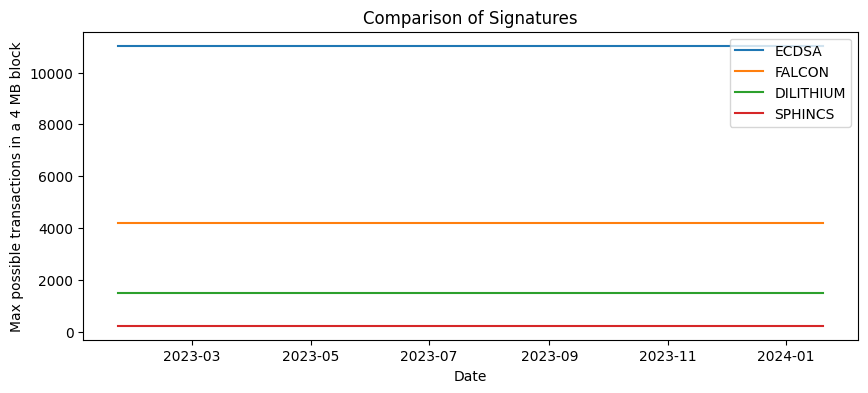

In [11]:
plt.figure(figsize=(10, 4))

plt.plot(ECDSA['Date'], ECDSA['NoMaxTxPossible'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['NoMaxTxPossible'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['NoMaxTxPossible'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['NoMaxTxPossible'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Max possible transactions in a 4 MB block')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

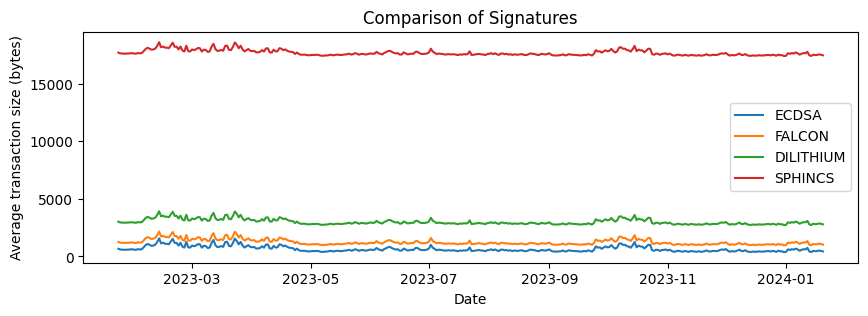

In [12]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA['Date'],ECDSA['AvgTxSize'], label='ECDSA')
plt.plot(ECDSA['Date'],FALCON['AvgTxSize'], label='FALCON')
plt.plot(ECDSA['Date'],DILITHIUM['AvgTxSize'], label='DILITHIUM')
plt.plot(ECDSA['Date'],SPHINCS['AvgTxSize'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transaction size (bytes)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

"Our results show that the PQ algorithms with the best performance for
time‐sensitive applications are Dilithium and Falcon." [Sikeridis et al., 2020](https://doi.org/10.14722/ndss.2020.24203)



### PROJECTIONS

#### TRANSACTION FEE FUNCTION (BITCOIN)

> Transaction fees (BTC) = Transaction size (in bytes) * Fee rate (BTC per byte)

where Fee rate depends on the market conditions and the network congestion

In [13]:
FALCON['FeePerTx'] = FALCON['AvgTxSize'] * ECDSA['AvgFeeRate']
DILITHIUM['FeePerTx'] = DILITHIUM['AvgTxSize'] * ECDSA['AvgFeeRate']
SPHINCS['FeePerTx'] = SPHINCS['AvgTxSize'] * ECDSA['AvgFeeRate']

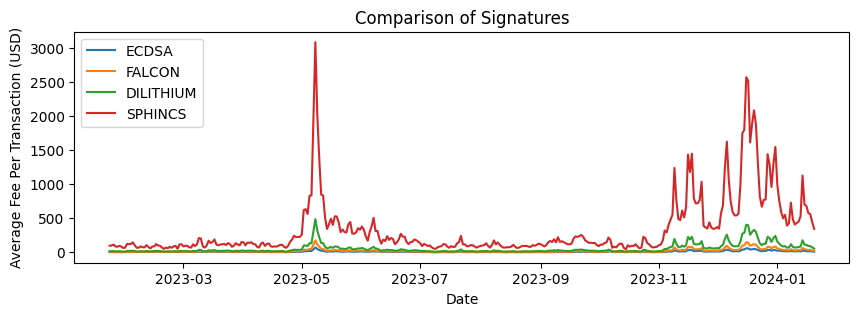

In [14]:
# Plot data from all three DataFrames
plt.figure(figsize=(10, 3))

plt.plot(ECDSA['Date'], ECDSA['FeePerTx'] * 65994 , label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['FeePerTx'] * 65994 , label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['FeePerTx'] * 65994 , label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['FeePerTx'] * 65994 , label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average Fee Per Transaction (USD)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

#### TRANSACTION THROUGHPUT

> Transactions per second = (block size/transaction size) / block time

#### AVERAGE TRANSACTIONS PER SECOND

> Average TPS = (Average Block Size / Average Transaction Size) / Average Block Time

In [15]:
ECDSA['AverageTPS'] = (ECDSA['AvgBlockSize'] / ECDSA['AvgTxSize']) / ECDSA['BlockTime']
FALCON['AverageTPS'] = (ECDSA['AvgBlockSize'] / FALCON['AvgTxSize']) / ECDSA['BlockTime']
DILITHIUM['AverageTPS'] = (ECDSA['AvgBlockSize'] / DILITHIUM['AvgTxSize']) / ECDSA['BlockTime']
SPHINCS['AverageTPS'] = (ECDSA['AvgBlockSize'] / SPHINCS['AvgTxSize']) / ECDSA['BlockTime']

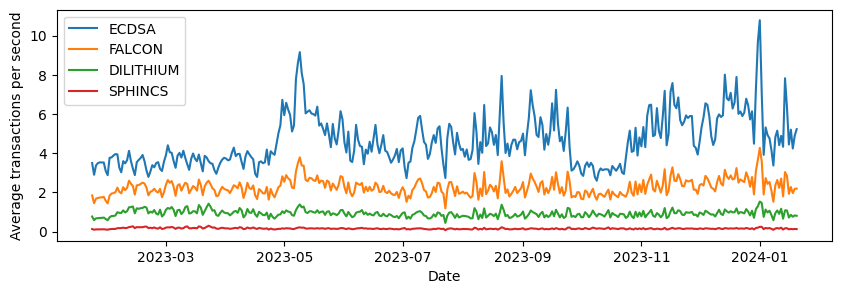

In [17]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA['Date'], ECDSA['AverageTPS'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['AverageTPS'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['AverageTPS'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['AverageTPS'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transactions per second')
# plt.title('Comparison of Signatures')
plt.legend()
plt.show()